### 一、数据清洗的概念与层级
######  （一）清洗1级 （二）清洗2级 （三）清洗三级

### （一）清洗1级    
1. 结构化的数据表 ，具有schema ，具有primary key 和 foreign key     
2. 列名称可编码，即符合编程语句能调用的标准，比如不应该有空格、特殊字符、编码语句特有含义字符     

In [ ]:
# 案例1 从文本非结构化数据库转变为结构化的表
from pathlib import Path
import pandas as pd
file_path = r"D:\1-script\3-PYTHON\python实战篇具体案例制作\git test dir\Hands-On-Data-Preprocessing-in-Python-main\Chapter09\Speeches"
# 生成一个想要查找文件的路径对象 WindowsPath
mypath = Path(file_path)
# 调用 recursive glob（Global Pathname Expansion）方法 递归匹配 文件名
txtpd =pd.DataFrame(columns = ['name','content'])
for i,txt_path in enumerate(mypath.rglob('*.txt'),start = 1):
    with open(txt_path,mode='r',encoding ='UTF-8') as f:
        name = txt_path.name
        text = f.read()         
        txtpd = pd.concat([txtpd , pd.DataFrame([[name,text]],columns = ['name','content'])],ignore_index=True,axis = 0 )

In [ ]:
# 2 案例2 过长的列标题可以用 列字典来简化

In [ ]:
# 补充案例1·采用的 pathlib import Path 做出的 <class 'pathlib.WindowsPath'> 类型
from pathlib import Path
path = r"D:\1-script\3-PYTHON\python实战篇具体案例制作\git test dir\Hands-On-Data-Preprocessing-in-Python-main\Chapter09\Speeches\CharlestonFeb28_2020.txt"
file_path = Path(path)
# 常用属性
print(file_path.name)   # 返回路径的最后一个组件（文件或目录名）
print(file_path.stem)   # 返回路径的基本名（不含扩展名）
print(file_path.suffix) # 返回文件的扩展名 比如.txt 但是文件夹没扩展名
print(file_path.parts)  # 返回路径各部件组成的元祖

# 常用方法
print(file_path.exists())  # 判断是否存在路径
print(file_path.is_dir())  # 判断是否为文件夹
print(file_path.is_file()) # 判断是否为文件
print(file_path.resolve()) # 返回路径的绝对路径，解析任何符号链接。

### （二）清洗2级
1. 为所采用的分析工具做出清洗
2. 改变数据结构 解包 重制表 重组表
3. 重构数据集

In [ ]:
# 案例一 数据隐藏在某个列中 比如json字典 比如一大串文本 解包旧表 重制新表
# 1. 前置准备
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
file_path = r"D:\1-script\3-PYTHON\python实战篇具体案例制作\git test dir\Hands-On-Data-Preprocessing-in-Python-main\Chapter09\Speeches"
# 生成一个想要查找文件的路径对象 WindowsPath
mypath = Path(file_path)
# 调用 recursive glob（Global Pathname Expansion）方法 递归匹配 文件名
txtpd =pd.DataFrame(columns = ['name','content'])
for i,txt_path in enumerate(mypath.rglob('*.txt'),start = 1):
    with open(txt_path,mode='r',encoding ='UTF-8') as f:
        name = txt_path.stem
        text = f.read()         
        txtpd = pd.concat([txtpd , pd.DataFrame([[name,text]],columns = ['name','content'])],ignore_index=True,axis = 0 )

#  2. 解析在列中的年月日城市等信息
# 定义一个简单函数解析 
def cut_name(name):
    monthes = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    for month in monthes:
        location = name.find(month) 
        if location != -1:
            break
    date = name[location:]
    city = name[0:location]
    return date,city

txtpd[['date','city']] =txtpd['name'].apply(cut_name).apply(pd.Series)
txtpd['date'] = pd.to_datetime(txtpd['date'],format = '%b%d_%Y')
txtpd['year'] = txtpd['date'].dt.year
txtpd['month'] = txtpd['date'].dt.month
txtpd['day'] = txtpd['date'].dt.day

# 3.简单解析content中词汇出现频数
txtpd['word_count'] = txtpd['content'].str.split(' ').str.len()
txtpd['r_vote']     = txtpd['content'].str.count('vote')/txtpd['word_count']
txtpd['r_tax']      = txtpd['content'].str.count('tax')/txtpd['word_count']
txtpd['r_campaign'] = txtpd['content'].str.count('campaign')/txtpd['word_count']
txtpd['r_economy']  = txtpd['content'].str.count('economy')/txtpd['word_count']

# 4.透视聚合数据 依赖于pivot_table 或者group by
# 采用period 可保留一定时间序列能力
txtpd['YM'] = txtpd['date'].dt.to_period('M')
# 'M': 月末（例如，转换为每个月的最后一天）。
# 'Q': 季度（例如，转换为每个季度的最后一天）。
# 'Y': 年（转换为每年的最后一天）。
# 'D': 日（转换为每一天）。
# 'H': 小时（转换为每小时）。
# 'T' 或 'min': 分钟（转换为每分钟）。
# 'S': 秒（转换为每秒）。

# 透视聚合或者分组聚合完成 年月日数据 聚合为 年月数据
df  = txtpd.pivot_table(index = ['YM'],values=['r_vote','r_tax','r_campaign','r_economy'],aggfunc = np.mean )
df1 = txtpd.groupby('YM').agg(   r_vote = ('r_vote', 'mean'), r_tax = ( 'r_tax', 'mean'), r_campaign = ( 'r_campaign', 'mean'), r_economy = ( 'r_economy', 'mean'),              )


# 绘图简易大法
fig = plt.figure(num = 1,figsize = (15,10),dpi = 100,facecolor = 'lightgray',edgecolor = 'black',frameon =True) # 改外层画布属性
ax1 = fig.add_subplot(1,2,1)
df.plot.bar(ax = ax1) # df自己就能根据数值的数量做到4个值占据一个x位置
# 也可以用barh绘制 横着的条形图



# 绘图复杂大法
ax2 = fig.add_subplot(1,2,2) 

# 设置条形宽度
bar_width = 0.2

# 生成 x 轴的位置
x = np.arange(len(df.index))  # 根据数据的长度生成 x 位置

# 绘制第一个条形图
ax2.bar(x, df['r_campaign'], width=bar_width, color='b', label='Campaign')

# 绘制第n个条形图，添加n个刻度偏移量
ax2.bar(x + 1 * bar_width, df['r_vote'],    width=bar_width, color='red',   label='Vote')
ax2.bar(x + 2 * bar_width, df['r_tax'],     width=bar_width, color='green', label='Tax')
ax2.bar(x + 3 * bar_width, df['r_economy'], width=bar_width, color='orange',label='Economy')

# 设置 x 轴的刻度和刻度标签
ax2.set_xticks(x + 1.5 * bar_width)  # 设置 x 轴刻度的位置
ax2.set_xticklabels(df.index.astype(str), rotation=45)  # 设置 x 轴标签

# 添加标签和标题
ax2.set_xlabel('Year-Month')
ax2.set_ylabel('Values')
ax2.set_title('Values by Year-Month')

# 添加图例
ax2.legend()

# 显示图形
plt.tight_layout()  # 调整布局以避免标签重叠
plt.show()

### （三）清洗3级-缺失值
1. 定位缺失值
2. 探究异常值
3. 处理异常值

###### 1.定位缺失值

In [ ]:
# 以如下数据集为例
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter11\Airdata.csv")

In [ ]:
# 定位所有缺失值的布尔索引方法
df.isna()

# 定位每个字段的缺失值总和 求和时布尔值为False 等价于 0 默认按照列聚合
df.isna().sum()

# # 定位每行数据 有几个缺失值  采用axis改变 求列为求行
# df.isna().sum(axis = 1)

# # 进一步筛选出 每行有多个缺失值的 
# df1 = df.isna().sum(axis = 1)>=2 # 这里是大于2的
# df1.sum()
    
# # 索引出缺失值行
# df[df.isna().any(axis = 1)] # 等价于 
# df[df.isna().sum(axis = 1)>=1]

###### 2.探究缺失原因                
（1） MCAR完全随机缺失 这列数据缺失与否 与其他任何特征之间不存在任何有意义的关系         
（2） MAR随机缺失   1这列数据缺失与否 至少与其他一个特征存在某种有意义的关系         
（3） MNAR非随机缺失  1这列数据缺失与否 至少与其他一个特征存在很强的关系         
（4） 特征相关分析方式：分类与数值 绘图查看 统计学双样本t检验  分类与分类 列联表 热力地图 卡方检验

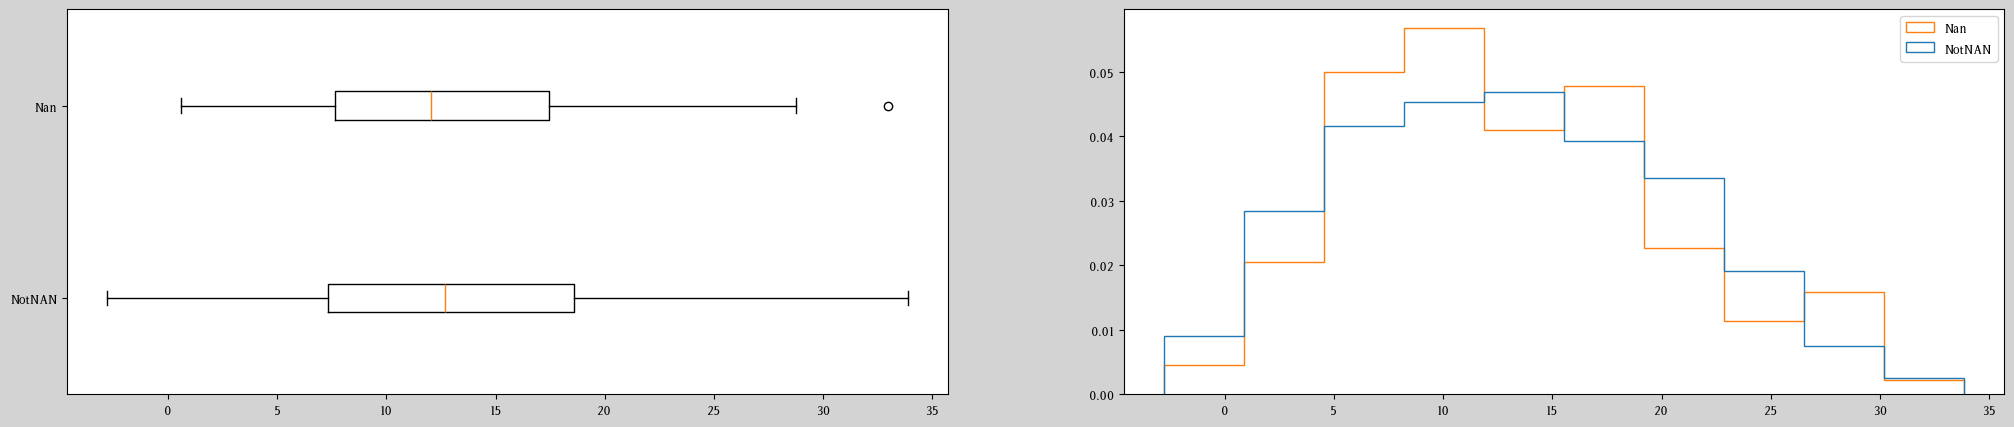

In [1]:
# 基于相关分析方式 我们先对 数值型的 执行计算
#### 步骤一 配置全局中文字体 配置负号ascii码展示 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

font_path = r'C:\\Users\\yaoyan\\AppData\\Local\\Microsoft\\Windows\\Fonts\\字魂45号-冰宇雅宋.ttf' #可修改全局字体
prop = fm.FontProperties(fname = font_path,weight = 'bold')
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

#### 步骤二 配置fig和axes 画几个子图 配置几个axes
fig = plt.figure(num = 1,figsize = (25,5),dpi = 100,facecolor = 'lightgray',edgecolor = 'black',frameon =True) # 改外层画布属性
ax1 = fig.add_subplot(1,2,1) 
ax2 = fig.add_subplot(1,2,2) 

#### 步骤三 准备数据集 重组适合箱型图的和直方图的
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter11\Airdata.csv")
BM = df['NO2_Location_A'].isna()
x = {'NotNAN': df[~BM]['Temperature'] , 'Nan':df[BM]['Temperature']}
ax1.boxplot(x.values(),vert = False,tick_labels = x.keys())
ax2.hist(x.values(),label = list(x.keys()),  histtype ='step',density =True) # 神奇的不接受字典的keys必须转为list
ax2.legend()
plt.show()


In [2]:
#### 步骤四 双样本t检验
import numpy as np
import scipy.stats as stats

## 分别计算两个样本的标准误 和 标准差
mean_notnan = x['NotNAN'].mean()
mean_nan = x['Nan'].mean()
std_notnan = np.std(x['NotNAN'],ddof = 1)
std_nan    = np.std(x['Nan']   ,ddof = 1)
n_notnan   = x['NotNAN'].shape[0]
n_nan      = x['Nan'].shape[0]

## 执行t检验之前 最好确保满足 样本独立性 正态分布 方差齐性  反之 采用Welch t 检验更为合理 可通过如下方式检查方差齐性
print(stats.anderson(x['NotNAN'] , dist='norm') ) # 看statistic=26.35480792571252 位于critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091])多少区间越是往上面越是显著 0.787对应5% 则推翻原始的正态分布假设
print(stats.anderson(x['Nan'] , dist='norm') )   
print(stats.levene(*x.values()) )  # 一样看p_value是否显著 不显著不推翻 方差齐性

## 方差齐性假设下 t 检验算法 equal_var=True
var_combined = ((n_notnan-1) * std_notnan ** 2 + (n_nan-1) * std_nan ** 2)/(n_notnan +n_nan -2) # 合并方差
se_combined  = np.sqrt( var_combined * (1/n_notnan + 1/n_nan) )

t = (mean_notnan - mean_nan) / se_combined

degree_of_freedom = n_notnan + n_nan - 2
p_value = 2 * stats.t.sf(abs(t),degree_of_freedom)
print(f'p_value:{p_value}')
Tresult = stats.ttest_ind(*x.values(),equal_var=True) # 默认True
print(f'Tresult:{Tresult}')


## 方差不齐假设下 t检验算法采用 Welch
se_notnan  = std_notnan / np.sqrt(n_notnan)
se_nan     = std_nan   /  np.sqrt(n_nan)
se_combined =np.sqrt(se_notnan **2 + se_nan ** 2)

t = (mean_notnan - mean_nan) / se_combined

dof_numerator = (se_notnan**2 + se_nan**2)**2
dof_denominator = (se_notnan**4/(n_notnan-1)) + (se_nan**4/(n_nan-1))
dof_welch = dof_numerator / dof_denominator

p_value_welch = 2 * stats.t.sf(abs(t),dof_welch)
print(f'p_value_welch:{p_value_welch}')

Tresult = stats.ttest_ind(*x.values(),equal_var=False)
print(f'Tresult:{Tresult}')


## 附录补充 计算临界t值
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha / 2, df=degree_of_freedom)
print(f"T 临界值: {t_critical}")

AndersonResult(statistic=26.35480792571252, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=13.11039046808241, scale=7.3680615067633015)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=0.769756347525643, critical_values=array([0.558, 0.636, 0.763, 0.89 , 1.059]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=13.148612226833333, scale=7.089807628510929)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
LeveneResult(statistic=0.9038142411410335, pvalue=0.3417871900245437)
p_value:0.9549726689684548
Tresult:TtestResult(statistic=-0.05646499065315542, pvalue=0.9549726689684548, df=8782.0)
p_value_welch:0.9533505752007123
Tresult:TtestResult(statistic=-0.05861956686641018, pvalue=0.9533505752007123, df=122.58647590384447)
T 临界值: 1.9602341499533

In [ ]:
### 步骤五 整合上述所有的检测 ，为一个统一示范 调用任何特征都将经过三类检测
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import numpy as np
import scipy.stats as stats

font_path = r'C:\\Users\\yaoyan\\AppData\\Local\\Microsoft\\Windows\\Fonts\\字魂45号-冰宇雅宋.ttf' #可修改全局字体
prop = fm.FontProperties(fname = font_path,weight = 'bold')
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter11\Airdata.csv")

def num_check(df,nan,column):
    
    BM = df[nan].isna()
    x = {'NotNAN': df[~BM][column] , 'Nan':df[BM][column]}
    
    fig = plt.figure(num = 1,figsize = (25,5),dpi = 100,facecolor = 'lightgray',edgecolor = 'black',frameon =True) # 改外层画布属性
    ax1 = fig.add_subplot(1,2,1) 
    ax2 = fig.add_subplot(1,2,2) 
    ax1.boxplot(x.values(),vert = False,labels = x.keys())
    ax2.hist(x.values(),label = list(x.keys()),  histtype ='step',density =True)
    ax2.legend()
    plt.show()
    
    Tresult = stats.ttest_ind(*x.values())
    print(f'''统计结果值为{ Tresult.pvalue }''')
    
columns = ['Temperature','Humidity','Wind_Speed','Wind_Direction']
for column in columns:
    num_check(df,nan = 'NO2_Location_B',column = column)

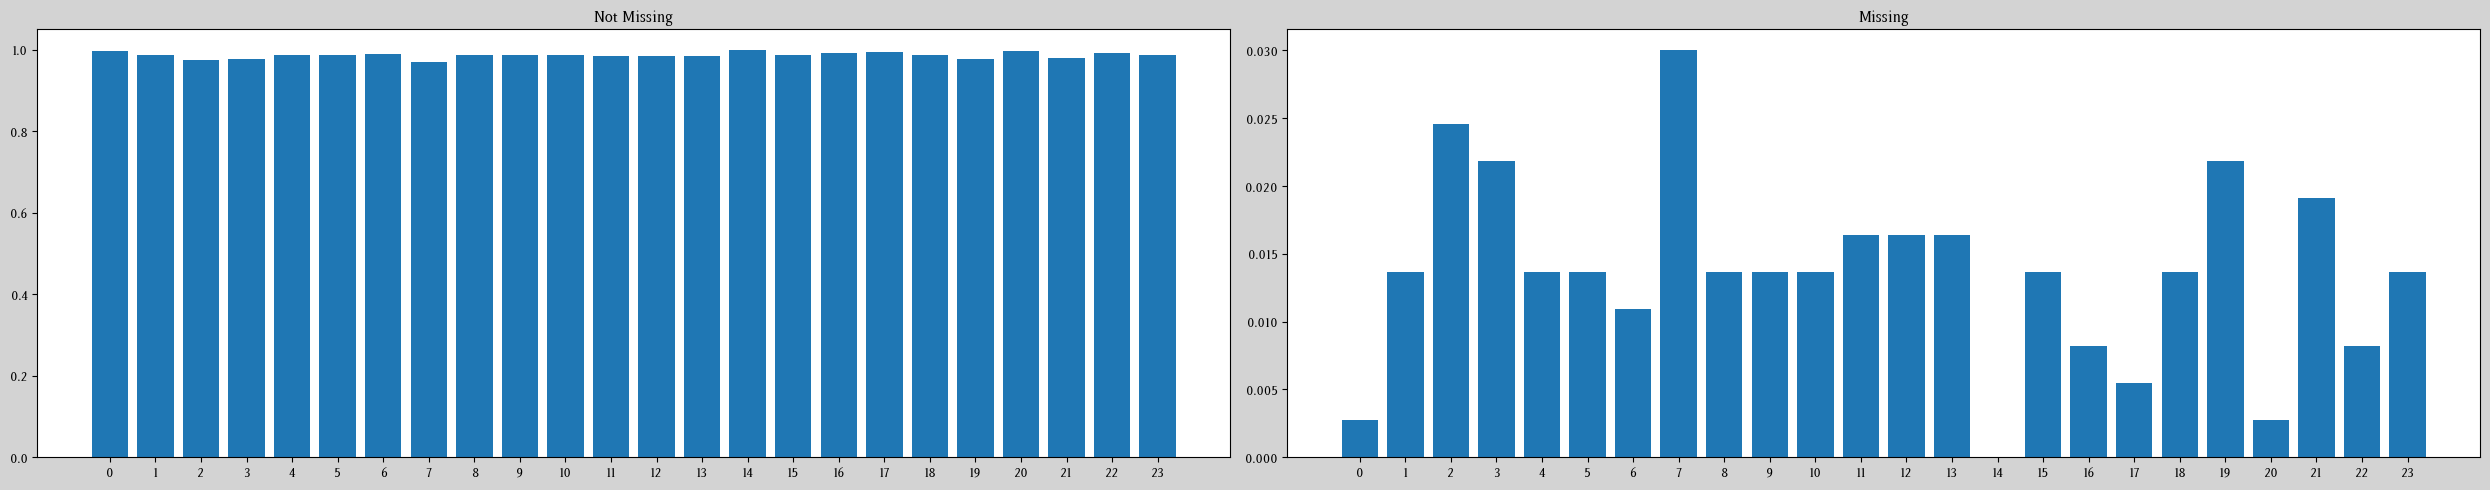

<Axes: xlabel='hour', ylabel='NO2_Location_A'>

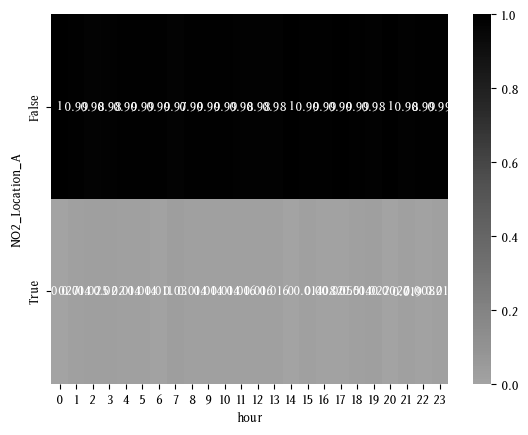

In [3]:
# 基于相关分析方式 我们继续对于 字符串类执行分析

# part1 我们来做看图说话
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import numpy as np
import scipy.stats as stats

# 先清洗出日期信息
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter11\Airdata.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day']   = df['DateTime'].dt.day
df['hour']  = df['DateTime'].dt.hour

# 预配置图标信息
font_path = r'C:\\Users\\yaoyan\\AppData\\Local\\Microsoft\\Windows\\Fonts\\字魂45号-冰宇雅宋.ttf' #可修改全局字体
prop = fm.FontProperties(fname = font_path,weight = 'bold')
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
fig = plt.figure(num = 1,figsize = (25,5),dpi = 100,facecolor = 'lightgray',edgecolor = 'black',frameon =True) # 改外层画布属性

# 准备数据
BM = df['NO2_Location_A'].isna()
total_series = df['hour'].value_counts().sort_values()
for i,poss in enumerate(BM.unique(),start =1):
    BMX = BM == poss
    part_series = df[BMX].hour.value_counts().sort_index()
    dfplt = pd.DataFrame(data= {'part':part_series ,'total': total_series} )
    dfplt['part_rate'] = part_series / total_series
    # 并绘画
    ax = fig.add_subplot(1,BM.unique().shape[0],i) 
    ax.bar(x =dfplt.index.astype(str)  ,height = dfplt['part_rate'],label = dfplt['part_rate'] )
    if poss:
        ax.set_title('Missing')
    elif not poss:
        ax.set_title('Not Missing')
        
# 调整并展示
plt.tight_layout()  # 调整子图间距
plt.show()
    

contingency = pd.crosstab(BM,df['hour'])
contingency_rate = contingency/contingency.sum()
import seaborn as sns
sns.heatmap(contingency_rate,annot = True , center = 0.075, cmap = 'Greys')


In [6]:
contingency.sum()

hour
0     366
1     366
2     366
3     366
4     366
5     366
6     366
7     366
8     366
9     366
10    366
11    366
12    366
13    366
14    366
15    366
16    366
17    366
18    366
19    366
20    366
21    366
22    366
23    366
dtype: int64

In [7]:
# part2 基于上面已经算过的 我们继续算卡方检验
# 基于大原本原理 且观察值独立时 才遵循卡方分布
# 卡方分布的临界值 基于自由度（行数-1）*（列数-1）也就是他的形状而改变 
# 通过卡方分布表，基于显著性和临界值查找到临界值  或者通过 stats.chi2.ppf(1-0.05,dof) 直接算出临界值
dof = (contingency.shape[0]-1) *  (contingency.shape[1]-1) 
chi2 = stats.chi2.ppf(1-0.05,dof)
print(f'自由度{dof},显著性0.05的情况下,卡方统计临界值: {chi2}') # 期望频数必须足够大（通常建议至少为5） 否则建议采用费舍尔精确检验

# 期望频数 Eij= 行总和*列总和 /样本总数
row_sum = contingency.sum(axis = 1 ).values
col_sum = contingency.sum(axis = 0).values
eij = row_sum[:,None] * col_sum /  df.shape[0]
print(f'期望频数为: {eij}')

# 卡方统计量  χ2 =∑ (Oij - Eij)**2 / Eij
dfx = (contingency - eij) **2 / eij
x2 = dfx.sum().sum()
print(f'实际的卡方统计值为: {x2}')

# 计算pvalue
pvalue = stats.chi2.sf(abs(x2),dof)
print(f'pvalue值为: {pvalue}')

# 和库计算结果比较 结果完全一致
chi2_result = stats.chi2_contingency(contingency)
chi2_result

自由度23,显著性0.05的情况下,卡方统计临界值: 35.17246162690806
期望频数为: [[361. 361. 361. 361. 361. 361. 361. 361. 361. 361. 361. 361. 361. 361.
  361. 361. 361. 361. 361. 361. 361. 361. 361. 361.]
 [  5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
    5.   5.   5.   5.   5.   5.   5.   5.   5.   5.]]
实际的卡方统计值为: 30.82105263157895
pvalue值为: 0.12725321642668141


Chi2ContingencyResult(statistic=30.82105263157895, pvalue=0.12725321642668141, dof=23, expected_freq=array([[361., 361., 361., 361., 361., 361., 361., 361., 361., 361., 361.,
        361., 361., 361., 361., 361., 361., 361., 361., 361., 361., 361.,
        361., 361.],
       [  5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
          5.,   5.]]))

In [ ]:
# part3 整合全部 封装函数
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import numpy as np
import scipy.stats as stats

def cate_check(df,nan,column):

    # 预配置图标信息
    font_path = r'C:\\Users\\yaoyan\\AppData\\Local\\Microsoft\\Windows\\Fonts\\字魂45号-冰宇雅宋.ttf' #可修改全局字体
    prop = fm.FontProperties(fname = font_path,weight = 'bold')
    plt.rcParams['font.sans-serif'] = prop.get_name()
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    fig = plt.figure(num = 1,figsize = (25,5),dpi = 100,facecolor = 'lightgray',edgecolor = 'black',frameon =True) # 改外层画布属性
    
    # 准备数据
    BM = df[nan].isna()
    total_series = df[column].value_counts().sort_values()
    
    for i,poss in enumerate(BM.unique(),start =1):
        BMX = BM == poss
        gen_part_series = lambda column : df[BMX][column].value_counts().sort_index()
        part_series = gen_part_series(column)
        
        dfplt = pd.DataFrame(data= {'part':part_series ,'total': total_series} )
        dfplt['part_rate'] = part_series / total_series
        # 并绘画
        ax = fig.add_subplot(1,BM.unique().shape[0],i) 
        ax.bar(x =dfplt.index.astype(str)  ,height = dfplt['part_rate'],label = dfplt['part_rate'] )
        if poss:
            ax.set_title('Missing')
        elif not poss:
            ax.set_title('Not Missing')
        
    # 调整并展示
    plt.tight_layout()  # 调整子图间距
    plt.show()
    
    # 执行卡方检验
    contingency = pd.crosstab(BM,df[column])
    result = stats.chi2_contingency(contingency)
    print(result.pvalue)
    
    # 分割线
    print('--------------------------------------')
    
# 先清洗出日期信息
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter11\Airdata.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['weekday'] = df['DateTime'].dt.day_name()
df['month'] = df['DateTime'].dt.month
df['day']   = df['DateTime'].dt.day
df['hour']  = df['DateTime'].dt.hour

columns =  ['month', 'day','hour', 'weekday']
nans    =  ['NO2_Location_A', 'NO2_Location_B','NO2_Location_C']
for nan in nans:
    for column in columns:
        print(nan,column)
        cate_check(df,nan,column)


###### 3.对缺失值进行处理               逻辑树见下方
（1） 不处理  对分析工具 分析目的无影响    
（2） 删除行  非常不建议 丢失数据样本       
（3） 删除列  仅仅在该列缺失值大于25%时考虑     
（4） 填充值  如使用一般集中趋势如均值 中位数 众数（MCAR） 更相关的一组数据的集中趋势如均值 中位数 众数(MAR)  回归分析（MNAR）    
MCAR MAR 仅仅在时间序列数据的时候采取插值df.series.interpolate   
集中趋势的选择逻辑异常值较多的时候采取中位数 反之取均值    

###### 1、分析必须的特征 是否为MNAR缺失  或者 是否具有超过25%的空值
1. yes
分析不可进行   
2. no
前往2    

###### 2、是否此项目只有你在使用，无其他人使用分析 
1. yes
保持缺失值别动 交付其他人 创建副本做你的项目然后前往3    
2. no
前往3

###### 3、是否你的分析工具和分析目标都可以接受存在空值
1. yes
保持缺失值别动 直接运行分析
2. no
前往4

###### 4、判断缺失值的类型
1. MCAR
前往5        
2. MAR
前往6       
3. MNAR
前往6 或者对你来说起始既然决定保留就说明是分析必须 ，分析必须出现MNAR会在第一步就被pass无法分析 所有这个让人费解      

###### 5、MCAR类型的缺失值 你要考虑造成空值的数据对象 是否有必须理由保存
1. yes         
需要执行估计和填补缺失值        
前往7                
2. no      
直接删除这行数据对象     

###### 6、MAR 和 MNAR类型的缺失值 你要考虑此列特征是否必须保留
1. yes         
需要执行估计和填补缺失值        
MAR前往8     
MNAR前往9
2. no      
直接删除这个特征


###### 7、MCAR类型的缺失值 填充  判断是否为时间序列数据
1. yes
df.column.interpolate
2. no
采取一般集中趋势填充 异常值多就走中位数 异常值较小就走平均值

###### 8、MAR类型的缺失值 填充  判断是否为时间序列数据
1. yes
df.column.interpolate
2. no
采取特定总体的集中趋势填充 异常值多就走中位数 异常值较小就走平均值

###### 9 、 MNAR类型的缺失值 填充 
1. 采取回归式填充

### （三）清洗3级-异常值
1. 定位异常值
2. 处理异常值

###### 1.定位异常值                
（1） 单变量异常值检测        
（2） 双变量异常值检测        
（3） 多变量异常值检测

In [ ]:
#### 单变量异常值检测
## 数值类 可采用四分位距检测 箱型图和直接用df.column.quantile()
# 箱型图
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter11\responses.csv")
fig = plt.figure(num = 1,figsize = (10,3),dpi = 100,facecolor = 'lightgray',edgecolor = 'black',frameon =True)
ax1 = fig.add_subplot(1,2,1)
box_info = ax1.boxplot(x = df.Weight.dropna(),labels = ['Weight'],vert = False)

plt.show()
filers = box_info['fliers'][0].get_xdata() # 水平绘制 提取x 反之提取y
print(f'离群值枚举值为{filers}')

# df.column.quantile()
q1 = df.Weight.quantile(0.25)
q3 = df.Weight.quantile(0.75)
IQR = q3 - q1
BM = ( ( df.Weight < (q1-IQR*1.5) ) |  ( df.Weight > (q3 + IQR*1.5) ) )
s1 = df[BM].Weight.value_counts()
print(f'离群值枚举值为{s1.index}')

## 分类类 频率表 或者 条形图
# 频率表 
s1 = df.Education.value_counts()
# 条形图
s1.plot.bar()

In [ ]:
#### 双变量异常值检测 探求两个特征之间的组合是否存在差异较大的组
## 数值与数值
# 散点图 观察图发现离群值的数值为  Weight < 70  和 Weight > 140
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
font_path = r'C:\\Users\\yaoyan\\AppData\\Local\\Microsoft\\Windows\\Fonts\\字魂45号-冰宇雅宋.ttf' #可修改全局字体
prop = fm.FontProperties(fname = font_path,weight = 'bold')
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter11\responses.csv")
fig = plt.figure(num = 1,figsize = (35,5),dpi = 100,facecolor = 'lightgray',edgecolor = 'black',frameon =True)
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('数值与数值 散点图看离群值')
sca_info = ax1.scatter(x = df.Weight, y=  df.Height )
ax1.set_xlabel('Weight')
ax1.set_ylabel('Height')
# BM = ( (df.Height < 70) | (df.Weight > 130) )  #可以多找到一个空值
BM = ( (df.Weight > 130) & (df.Height > 190) ) | ( (df.Weight < 70) & (df.Height < 80) )   # 完全根据观察的点来写xy限制 会少一个空值，但是更加精确
df[BM]


## 分类与分类 他把god当做是离散型的分类用 而非其固有的数值属性 
# 颜色编码列联表 
contingency = pd.crosstab(df.Education,df.God) # 对于频度等于1的即为异常值 其实就是出现的这个组合的样本量太少了
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('分类与分类 颜色编码列联表')
sns.heatmap(contingency,annot = True, cmap = 'Greys' ,ax = ax2)
df.query( """Education == 'currently a primary school pupil' &  God ==2  """   )
df.query( """Education == 'currently a primary school pupil' &  God ==4  """   )
df.query( """Education == 'doctorate degree' &  God ==1 """   )
df.query( """Education == 'doctorate degree' &  God ==2 """   )
df.query( """Education == 'doctorate degree' &  God ==3 """   )

## 分类与数值
# 多箱型图比较 其实就比单变量异常值多了个基于分类的多元分组的步骤 再每个组下面寻找异常的离群值
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('分类与数值 箱型图比较')
sns.boxplot(x = df.Age, y= df.Education, ax= ax3)
plt.show()
fig.savefig(r"异常值定位 双特征.png")
BM1 =( ( df.Education == 'college/bachelor degree' ) & (df.Age >26) )
BM2 =( ( df.Education == 'secondary school' ) & ( (df.Age >24)  | (df.Age <16) )  )
BM3 =( ( df.Education == 'primary school' )   & ( (df.Age >19)  | (df.Age <16) )  )
BM = BM1 | BM2 | BM3
df[BM]

In [ ]:
#### 多变量异常值检测 
## 聚类分析
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
df = pd.read_csv(r"D:\1-script\3-PYTHON\data存储jupyter用的个文件类型数据\Hands-On-Data-Preprocessing-in-Python-main\Chapter11\responses.csv")
dimensions = ['Country', 'Metal or Hardrock','Folk','Musical']
df = df[dimensions]

# 检查下是否存在数据对象有过多的缺失值 
if df[df.isna().sum(axis = 1)>2].empty:
    print('不存在一个数据对象 存在2个以上的空值')
else:
     print('存在一个数据对象 存在2个以上的空值')
        
# 检查下缺失值情况
df.isna().sum()

# 判断缺失原因 避免存在篡改数据集 
def num_check(df,nan,column):
    
    BM = df[nan].isna()
    x = {'NotNAN': df[~BM][column].dropna() , 'Nan':df[BM][column].dropna()}
#     fig = plt.figure(num = 1,figsize = (25,5),dpi = 100,facecolor = 'lightgray',edgecolor = 'black',frameon =True) # 改外层画布属性
#     ax1 = fig.add_subplot(1,2,1) 
#     ax2 = fig.add_subplot(1,2,2) 
#     ax1.boxplot(x.values(),vert = False,labels = x.keys())
#     ax2.hist(x.values(),label = list(x.keys()),  histtype ='step',density =True)
#     ax2.legend()
#     plt.show()
    Tresult = stats.ttest_ind(*x.values())
    print(f'''统计结果值为{ Tresult.pvalue }''')
    return Tresult.pvalue 

for nan in df.columns:
    for column in [col for col in df.columns if col != nan]:
        if num_check(df,nan,column) < 0.05:
            print(nan,column)
        else:
            print('缺失与提取的特征无任何关系')
            

# 既然无任何相关为MCAR，非时间序列，一般应该走集中趋势填充
# 但是这是为了判断异常值，走集中趋势会让异常离群值 靠近群体 所以是不允许的
# 此时因为是MCAR 建议采用Q3+1.5*IQR来填充 最大化的识别异常值
dffillna = df.quantile(0.75) + 1.5 * (df.quantile(0.75) - df.quantile(0.25))
dfx = df.fillna(dffillna) 

# kmeans适合采用最大最小化归一法 一般会压缩数据在0-1中 适合不假设数据为某种分布的算法
dfmaxmin = ( dfx - dfx.min() ) / ( dfx.max() - dfx.min() )

# 对于超参数k 选择多个k值最小化 kmeans超参调整产生的弱点
# 下面实验了2-7的群组并打印出来每个群组的样本数
from sklearn.cluster import KMeans  # set OMP_NUM_THREADS=4 启动jupyter前先用命令窗口注入环境变量 然后在用同一个命令窗口启动jupyter
for k in range(2,8):  
    kmeans = KMeans(n_clusters = k, n_init = 10)
    kmeans.fit(dfmaxmin)
    print(f'k ={k}')
    for i in range(k):
        BM = kmeans.labels_ == i
        print(f'cluster群组{i}，次群组的个数为：{len(df[BM].index.values)}')


#### 补充聚类相关知识
## kmeans拟合完成后如何查看聚类的结果

# 获取每个样本的分类标签
labels = kmeans.labels_
df['label'] = labels 
print(f'本次聚类标签如下')
print(df.label.value_counts().sort_index())

# 获取聚类中心
centers = kmeans.cluster_centers_
print('kmeans的质心和其热力地图如下 ')
print(centers)
sns.heatmap(centers,annot= True,cmap='Greys')

###### 2.处理异常值   part1 看检查出来的方式决定必须处理时的做法            
（1） 尽量保持原封不动           
（2） 实在需要处理时 单变量检查出来的异常值      双变量检查分类-数值的异常值     数值类可以替换为上下限          
（3） 实在需要处理时 当特征遵循指数分布时 才采取应用对数变化         
（4） 实在需要处理   多变量检测的 双变量非分类-数值检测的 只能选择删除          
            
part 2  看分析目的和分析工具能否接受           
典型的如直方图，sns的回归散点图 可视化维度颜色大小等 会因为异常值占据图画位置 导致部分数据不展开的情况时，可以删除异常点          
典型的如同箱型图 条形图 时间序列图 列联表 对于异常值的敏感性没有那么强大 不处理正常绘画也没问题        
典型的如同线性回归 kmeans聚类 knn近邻算法都是对于异常值敏感的 可以做替换为上下限的处理         
典型的如同MLP 决策树 对于异常值不太敏感 可以保持原样             

### （三）清洗3级-误差值    
Data = True Signal + Error    
1. 随机误差     
2. 系统误差    

随机误差： 受限于测量系统或者数据呈现的无能，随机误差永远存在 比如7个温度计 每个温度计对于室温的测量存在不同的结果 这个是无法避免的  
系统误差： 被持续收集数据过程中的某个固定问题困扰所产生的误差 这个是可修复可避免掉的         

随机误差：通过平滑或者聚合方式减轻 在数据按摩与转化章节介绍    
系统误差：找到引发的问题点，解决掉 并采取其他收集到的数据 实在没有可替换的，则视作缺失值来处理    

系统误差和正确的异常值的区别主要在于 找不到任何理由解释数据异常时就可以视为系统误差 